In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "Project2Data.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


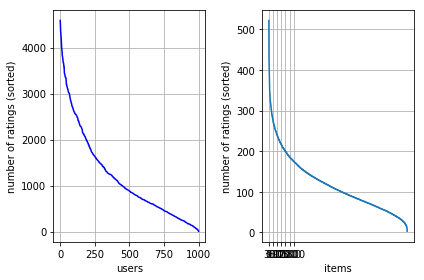

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))
#displaying of data for items needs fixing, probably d too small

In [7]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    print(num_rows)
    print(num_cols)
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))
    
    nz_items, nz_users = valid_ratings.nonzero()
    
    # split data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]
    
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test
valid_ratings, train, test = split_data(ratings, num_items_per_user, num_users_per_item, 0, 0.1)

10000
1000
the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (10000, 1000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065327
Total number of nonzero elements in test data:111625


In [8]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    num_item, num_user = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    return user_features, item_features

In [9]:
user_features, item_features = init_MF(train, 20)
print(item_features.shape)
print(user_features.shape)
print(train.shape)

(20, 10000)
(20, 1000)
(10000, 1000)


In [16]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [17]:
def matrix_factorization_SGD(train, test, lambda_user, lambda_item, gamma, K, iterMax):
    """matrix factorization by SGD."""
    # define parameters
    gamma = gamma
    num_features = K   # K in the lecture notes
    lambda_user = lambda_user
    lambda_item = lambda_item
    num_epochs = iterMax     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            err = train[d, n] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    return rmse


In [18]:
def matrix_factorization_SGD_all(train, test, lambda_user, lambda_item, gamma, K, iterMax):
    """matrix factorization by SGD."""
    # define parameters
    gamma = gamma
    num_features = K   # K in the lecture notes
    lambda_user = lambda_user
    lambda_item = lambda_item
    num_epochs = iterMax     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            err = train[d, n] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    return rmse, user_features, item_features

In [29]:
gamma = 0.02  #0.03 best for K = 20 and initial
rmse_ev = np.zeros([3,3])
lambda_user = [0.01, 0.05, 0.1]  #best for K = 20 and gamma = 0.03 initial
lambda_item = [0.1, 0.2, 0.5]  #best for K = 20 lu = 0.02 and gamma = 0.03
num_features = 15   # K in the lecture notes
num_epochs = 10
i = 0
for lu in lambda_user:
    i += 1
    j = 0
    for li in lambda_item:
        j += 1
        print("ROUND {},{}:".format(i,j))
        rmse_ev[i-1, j-1] = matrix_factorization_SGD(train, test, lu, li, gamma, num_features, num_epochs)

ROUND 1:
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.049632360853516.
iter: 1, RMSE on training set: 1.020243267982725.
iter: 2, RMSE on training set: 1.0002199574032948.
iter: 3, RMSE on training set: 0.9862894450076296.
iter: 4, RMSE on training set: 0.9729548735154872.
iter: 5, RMSE on training set: 0.9609459920159176.
iter: 6, RMSE on training set: 0.9524951700296076.
iter: 7, RMSE on training set: 0.9447869899052078.
iter: 8, RMSE on training set: 0.9386746993758812.
iter: 9, RMSE on training set: 0.9339996050808759.
RMSE on test data: 1.0123675593615962.
ROUND 2:
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0397563719029288.
iter: 1, RMSE on training set: 1.0161499347899725.
iter: 2, RMSE on training set: 1.0016438189094534.
iter: 3, RMSE on training set: 0.9901798424824607.
iter: 4, RMSE on training set: 0.9775786548229987.
iter: 5, RMSE on training set: 0.9659991072591453.
iter: 6, RMSE on training set: 0.95679740

In [20]:
print(rmse_ev)

[[1.00338357 1.00326083 1.00456928]
 [1.00341493 1.00323543 1.00462914]
 [1.00405953 1.00393648 1.00545454]]


**Evaluating the results**

Leave the rest of the code above as it is and only work with the stuff below

In [21]:
gamma = 0.02  #0.03 best for K = 20 and initial
lambda_user = 0.03 #best for K = 20 and gamma = 0.03 initial
lambda_item = 0.15  #best for K = 20 lu = 0.02 and gamma = 0.03
num_features = 5# K in the lecture notes
num_epochs = 20 

rmse_ev, Z, W  = matrix_factorization_SGD_all(train, test, lambda_user, lambda_item, gamma, num_features, num_epochs)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.050126919981355.
iter: 1, RMSE on training set: 1.0225215943770478.
iter: 2, RMSE on training set: 1.0076296712272828.
iter: 3, RMSE on training set: 1.0008576142759364.
iter: 4, RMSE on training set: 0.9961661440532399.
iter: 5, RMSE on training set: 0.9914289947696661.
iter: 6, RMSE on training set: 0.9888327994671374.
iter: 7, RMSE on training set: 0.9862181778032121.
iter: 8, RMSE on training set: 0.9836731263175907.
iter: 9, RMSE on training set: 0.9820409403228237.
iter: 10, RMSE on training set: 0.9806163551286149.
iter: 11, RMSE on training set: 0.9796549112360273.
iter: 12, RMSE on training set: 0.9786522233614954.
iter: 13, RMSE on training set: 0.9777877813307858.
iter: 14, RMSE on training set: 0.9773366942458743.
iter: 15, RMSE on training set: 0.9767997375131514.
iter: 16, RMSE on training set: 0.9763927293071198.
iter: 17, RMSE on training set: 0.9761353815559234.
iter: 18, RMSE on training set:

In [22]:
Z.shape

(5, 1000)

In [23]:
W.shape

(5, 10000)

In [24]:
def deal_lines(line):
    row_cols = line[0]
    r, c = row_cols.split("_")
    row = r[1:]
    col = c[1:]
    return int(row), int(col)

In [25]:
def read_Sample(path):
    import csv
    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        rows = list()
        cols = list()
        for row in csv_reader:
            csv_reader = [deal_lines(line) for line in csv_reader]
    return csv_reader

In [26]:
from helpers import load_data, preprocess_data

sampleSub = "SampleSubmission.csv"
data = read_Sample(sampleSub)
indices = np.asarray(data);
print(len(indices))

1176952


In [27]:
def calcValue(rows, cols):
    value = int(round(Z[:,cols].dot(W[:,rows].T)))
    a = [1, 2, 3, 4, 5]
    if value not in a:
        if value > 5:
            value = 5
        if value < 1:
            value = 1
    return value

In [28]:
def writeSubFile(indices):
    import csv
    with open('SubmissionFile.csv', mode='w') as submF:
        writer = csv.writer(submF, delimiter=',', quotechar='', quoting=csv.QUOTE_NONE , lineterminator = '\n')
        writer.writerow(['Id','Prediction'])
        tot = 0
        for row, col in indices:
            msg = 'r'+str(row)+'_c'+str(col)
            value = calcValue(row-1, col-1)
            writer.writerow([msg, value])
            tot += 1
        print(tot)
writeSubFile(indices)

1176952
